In [8]:
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.insert(1, "../")

import utils.scores as scores
import utils.anomaly as anomaly
import utils.us_map

In [9]:
states = utils.us_map.main("../data/cb_2018_us_state_500k")
act_sat_conv = pd.read_excel("../data/act_sat_conversion.xlsx", skiprows=1)

Text(0.5, 0, 'ACT Score')

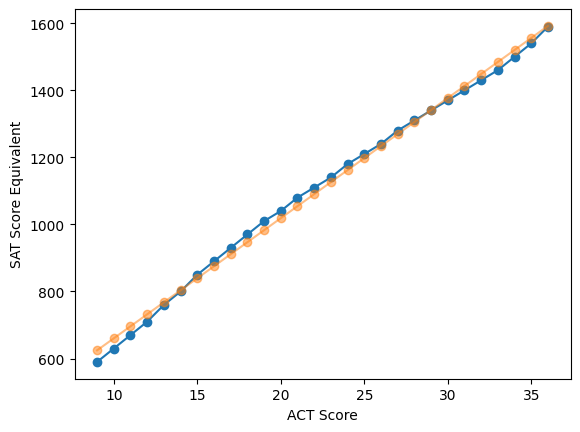

In [10]:
plt.plot(act_sat_conv.ACT, act_sat_conv.SAT, marker="o")
act_sat_reg = scipy.stats.linregress(act_sat_conv.ACT, act_sat_conv.SAT)
reg_values = anomaly.linear(
    act_sat_conv.ACT, act_sat_reg.slope, act_sat_reg.intercept)
plt.plot(act_sat_conv.ACT, reg_values, marker="o", alpha=0.5)
plt.ylabel("SAT Score Equivalent")
plt.xlabel("ACT Score")

In [11]:
s1 = scores.SATScores("../data/sat/tabn226.40_17_18_19_20.xlsx")
s2 = scores.SATScores("../data/sat/tabn226.40_18_21_22_23.xlsx")
s2.df = s2.df.query("year!=2018")

In [12]:
paths = ['../data/act/tabn226.60_2013_2017.xlsx',
         '../data/act/tabn226.60_2014_2018.xlsx',
         '../data/act/tabn226.60_2015_2019.xlsx',
         '../data/act/tabn226.60_2016_2020.xlsx',
         '../data/act/tabn226.60_2017_2021.xlsx',
         '../data/act/tabn226.60_2018_2022.xlsx',
         '../data/act/tabn226.60_2018_2023.xlsx']

objs = [scores.ACTScores(path) for path in paths]
objs[0].df = objs[0].df.query("year==2013")
objs[1].df = objs[1].df.query("year==2014")

In [13]:
test_scores = scores.Scores()

for score in [s1, s2] + objs:
    test_scores = test_scores.merge(score)

test_scores.df

,location,year,percent,section,mean,test
0,United States,2017,47.605306,total,1060.0,SAT
1,Alabama,2017,5.000000,total,1165.0,SAT
2,Alaska,2017,38.000000,total,1080.0,SAT
3,Arizona,2017,30.000000,total,1116.0,SAT
4,Arkansas,2017,3.000000,total,1208.0,SAT
...,...,...,...,...,...,...
515,Virginia,2023,8.000000,science,24.3,ACT
516,Washington,2023,6.000000,science,24.2,ACT
517,West Virginia,2023,26.000000,science,20.1,ACT
518,Wisconsin,2023,95.000000,science,19.8,ACT


In [14]:
act_scores = test_scores.get_section("composite").df
act_scores_conv_df = act_scores.assign(SAT_equiv=anomaly.linear(
    act_scores["mean"], act_sat_reg.slope, act_sat_reg.intercept))

In [15]:
sat_scores = test_scores.get_section("total").df
combined_scores = (sat_scores.merge(act_scores_conv_df, on=["location", "year"])
                             .rename({"percent_x": "SAT_percent",
                                      "mean_x": "SAT_mean",
                                      "percent_y": "ACT_percent"}, axis=1))
combined_scores

,location,year,SAT_percent,section_x,SAT_mean,test_x,ACT_percent,section_y,mean_y,test_y,SAT_equiv
0,United States,2017,47.605306,total,1060.0,SAT,56.334392,composite,21.0,ACT,1054.466338
1,Alabama,2017,5.000000,total,1165.0,SAT,100.000000,composite,19.2,ACT,989.968801
2,Alaska,2017,38.000000,total,1080.0,SAT,65.000000,composite,19.8,ACT,1011.467980
3,Arizona,2017,30.000000,total,1116.0,SAT,62.000000,composite,19.7,ACT,1007.884784
4,Arkansas,2017,3.000000,total,1208.0,SAT,100.000000,composite,19.4,ACT,997.135194
...,...,...,...,...,...,...,...,...,...,...,...
411,Virginia,2023,49.000000,total,1113.0,SAT,8.000000,composite,24.6,ACT,1183.461412
412,Washington,2023,37.000000,total,1081.0,SAT,6.000000,composite,24.5,ACT,1179.878216
413,West Virginia,2023,90.000000,total,923.0,SAT,26.000000,composite,20.3,ACT,1029.383963
414,Wisconsin,2023,2.000000,total,1236.0,SAT,95.000000,composite,19.4,ACT,997.135194


In [16]:
majority_mean = np.where(combined_scores["ACT_percent"] > combined_scores["SAT_percent"],
                         combined_scores["SAT_equiv"],
                         combined_scores["SAT_mean"])

majority_percent = np.where(combined_scores["ACT_percent"] > combined_scores["SAT_percent"],
                            combined_scores["ACT_percent"],
                            combined_scores["SAT_percent"])

combined_scores = (combined_scores.assign(mean=majority_mean)
                                  .assign(percent=majority_percent))

combined_scores.head()

,location,year,SAT_percent,section_x,SAT_mean,test_x,ACT_percent,section_y,mean_y,test_y,SAT_equiv,mean,percent
0,United States,2017,47.605306,total,1060.0,SAT,56.334392,composite,21.0,ACT,1054.466338,1054.466338,56.334392
1,Alabama,2017,5.000000,total,1165.0,SAT,100.000000,composite,19.2,ACT,989.968801,989.968801,100.000000
2,Alaska,2017,38.000000,total,1080.0,SAT,65.000000,composite,19.8,ACT,1011.467980,1011.467980,65.000000
3,Arizona,2017,30.000000,total,1116.0,SAT,62.000000,composite,19.7,ACT,1007.884784,1007.884784,62.000000
4,Arkansas,2017,3.000000,total,1208.0,SAT,100.000000,composite,19.4,ACT,997.135194,997.135194,100.000000


<Axes: xlabel='year', ylabel='mean'>

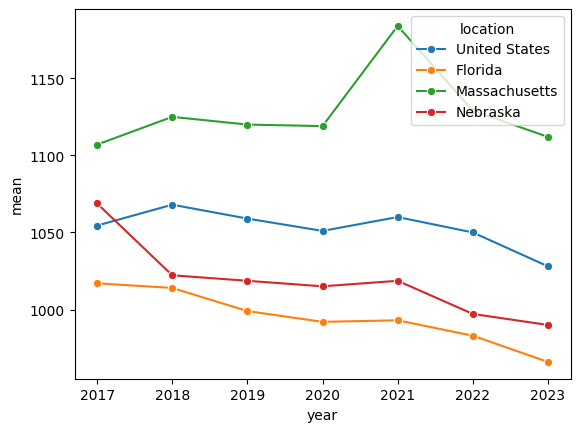

In [17]:
demonstration_locals = ["Nebraska",
                        "Massachusetts", "United States", "Florida"]

sns.lineplot(data=combined_scores.query("location in @demonstration_locals"),
             x="year",
             y="mean",
             hue="location",
             marker="o")

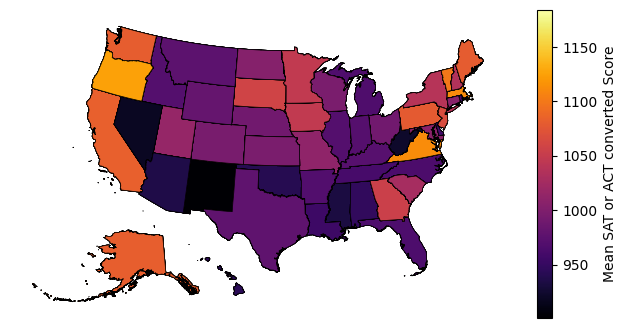

In [18]:
states.merge(combined_scores, left_on="NAME", right_on="location")\
    .plot(column="mean",
          legend=True,
          cmap="inferno",
          edgecolor="black",
          figsize=(8, 8),
          lw=0.5,
          legend_kwds={"label": "Mean SAT or ACT converted Score",
                       "shrink": 0.5})

plt.axis("Off")
plt.show()

In [19]:
rankings = combined_scores.pivot_table(
    index="location", columns="year", values="mean").sort_values(2023, ascending=False).reset_index()
rankings.columns.name = "2023 Rankings"
rankings.index = rankings.index + 1
rankings.round(1)

2023 Rankings,location,2017,2018,2019,2020,2021,2022,2023
1,Oregon,1108.0,1117.0,1112.0,1104.0,1040.1,1143.0,1125.0
2,Virginia,1102.0,1117.0,1119.0,1116.0,1151.0,1124.0,1113.0
3,Massachusetts,1107.0,1125.0,1120.0,1119.0,1184.0,1129.0,1112.0
4,Vermont,1114.0,1120.0,1106.0,1103.0,1124.0,1095.0,1099.0
5,California,1055.0,1076.0,1065.0,1049.0,1057.0,1115.0,1083.0
6,Alaska,1011.5,1106.0,1097.0,1098.0,1119.0,1110.0,1082.0
7,Washington,1075.0,1081.0,1074.0,1073.0,1072.0,1096.0,1081.0
8,Maine,1012.0,1013.0,1013.0,995.0,1099.0,1081.0,1080.0
9,Pennsylvania,1071.0,1086.0,1082.0,1078.0,1123.0,1091.0,1078.0
10,New Jersey,1056.0,1094.0,1090.0,1081.0,1125.0,1079.0,1066.0


In [20]:
combined_scores.query("location == 'North Dakota'")

,location,year,SAT_percent,section_x,SAT_mean,test_x,ACT_percent,section_y,mean_y,test_y,SAT_equiv,mean,percent
35,North Dakota,2017,2.0,total,1256.0,SAT,98.0,composite,20.3,ACT,1029.383963,1029.383963,98.0
122,North Dakota,2018,2.0,total,1283.0,SAT,98.0,composite,20.3,ACT,1029.383963,1029.383963,98.0
123,North Dakota,2018,2.0,total,1283.0,SAT,98.0,composite,20.3,ACT,1029.383963,1029.383963,98.0
191,North Dakota,2019,2.0,total,1263.0,SAT,96.0,composite,19.9,ACT,1015.051177,1015.051177,96.0
243,North Dakota,2020,2.0,total,1231.0,SAT,94.0,composite,19.6,ACT,1004.301587,1004.301587,94.0
295,North Dakota,2021,1.0,total,1258.0,SAT,100.0,composite,19.6,ACT,1004.301587,1004.301587,100.0
347,North Dakota,2022,1.0,total,1212.0,SAT,96.0,composite,19.2,ACT,989.968801,989.968801,96.0
399,North Dakota,2023,1.0,total,1287.0,SAT,89.0,composite,19.6,ACT,1004.301587,1004.301587,89.0


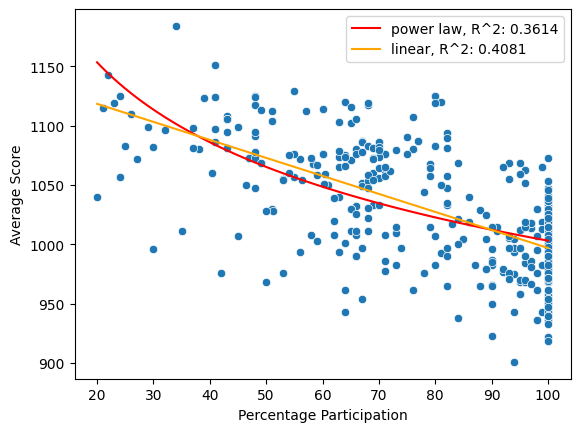

In [21]:
anomaly.anomaly(combined_scores, separate_years=False)
combined_corrected_scores = anomaly.anomaly(
    combined_scores, separate_years=True, suppress=True)
combined_corrected_scores = combined_corrected_scores.assign(
    anom_c=combined_corrected_scores["mean"]-combined_corrected_scores["lin_pred"])

<Axes: xlabel='year', ylabel='anom_c'>

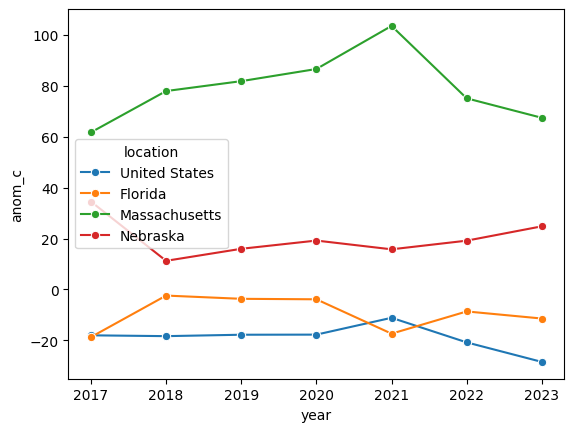

In [22]:
sns.lineplot(data=combined_corrected_scores.query("location in @demonstration_locals"),
             x="year",
             y="anom_c",
             marker="o",
             hue="location")

In [23]:
rankings = combined_corrected_scores.pivot_table(
    index="location", columns="year", values="anom_c").sort_values(2023, ascending=False).reset_index()
rankings.columns.name = "2023 Rankings"
rankings.index = rankings.index + 1
rankings.round(1)

2023 Rankings,location,2017,2018,2019,2020,2021,2022,2023
1,Massachusetts,61.7,77.9,81.8,86.5,103.4,75.0,67.4
2,Virginia,41.5,48.2,56.4,56.1,80.9,56.4,52.1
3,New Hampshire,34.3,44.8,47.0,46.3,39.7,46.7,41.3
4,Utah,17.2,22.0,26.7,30.0,37.3,31.2,37.7
5,Connecticut,28.8,42.0,43.3,43.2,43.7,37.3,35.7
6,New Jersey,2.4,50.5,53.6,52.2,65.4,40.6,35.6
7,Vermont,46.6,44.0,39.7,39.4,53.9,27.4,29.9
8,Wisconsin,24.3,25.6,26.7,26.4,30.7,17.2,29.9
9,Wyoming,13.6,7.7,8.8,12.0,16.1,23.7,25.8
10,Minnesota,60.2,52.4,56.8,54.7,34.3,27.8,25.1


,location,year,SAT_percent,section_x,SAT_mean,test_x,ACT_percent,section_y,mean_y,test_y,SAT_equiv,mean,percent,lin_pred,plaw_pred
0,United States,2017,47.605306,total,1060.0,SAT,56.334392,composite,21.0,ACT,1054.466338,1054.466338,56.334392,1072.451745,1073.863725
1,Alabama,2017,5.000000,total,1165.0,SAT,100.000000,composite,19.2,ACT,989.968801,989.968801,100.000000,1012.231550,1013.888680
2,Alaska,2017,38.000000,total,1080.0,SAT,65.000000,composite,19.8,ACT,1011.467980,1011.467980,65.000000,1060.500816,1058.586028
3,Arizona,2017,30.000000,total,1116.0,SAT,62.000000,composite,19.7,ACT,1007.884784,1007.884784,62.000000,1064.638182,1063.607301
4,Arkansas,2017,3.000000,total,1208.0,SAT,100.000000,composite,19.4,ACT,997.135194,997.135194,100.000000,1012.231550,1013.888680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,Virginia,2023,49.000000,total,1113.0,SAT,8.000000,composite,24.6,ACT,1183.461412,1113.000000,49.000000,1060.918986,1049.645199
412,Washington,2023,37.000000,total,1081.0,SAT,6.000000,composite,24.5,ACT,1179.878216,1081.000000,37.000000,1085.364376,1084.640963
413,West Virginia,2023,90.000000,total,923.0,SAT,26.000000,composite,20.3,ACT,1029.383963,923.000000,90.000000,977.397235,977.718254
414,Wisconsin,2023,2.000000,total,1236.0,SAT,95.000000,composite,19.4,ACT,997.135194,997.135194,95.000000,967.211656,971.565720


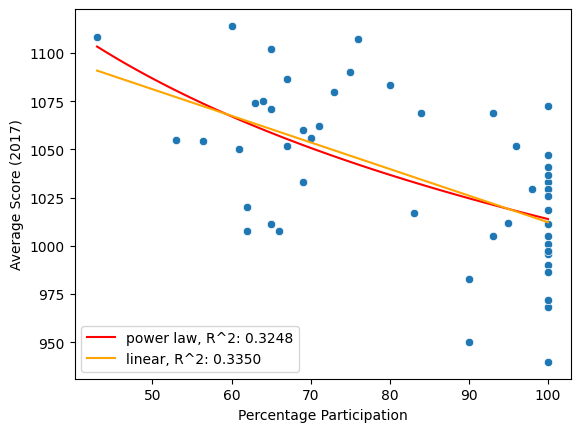

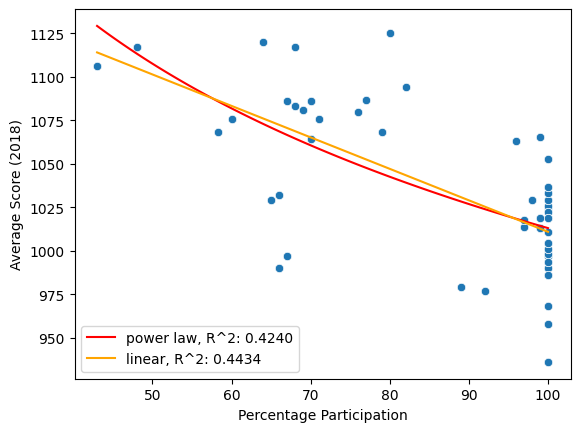

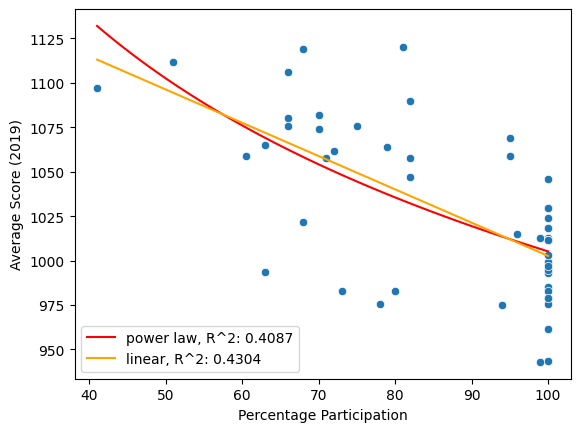

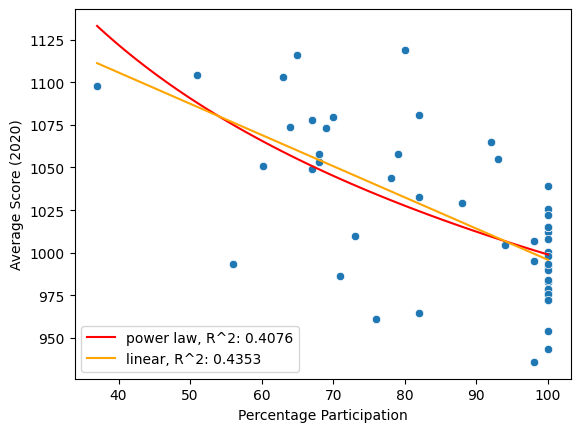

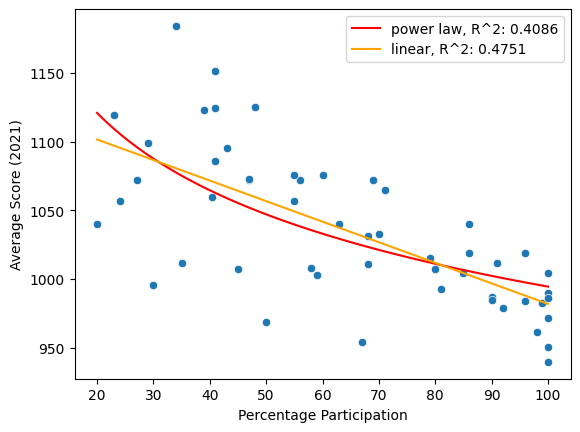

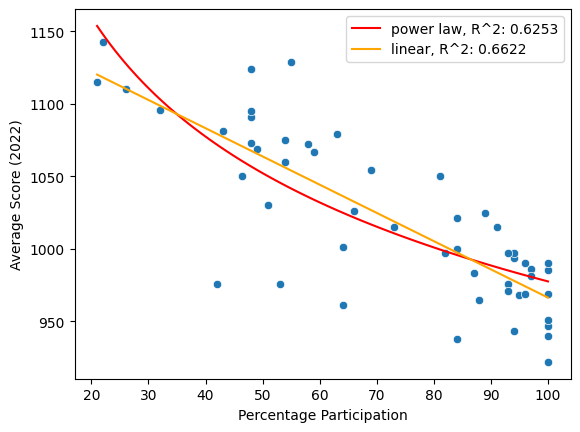

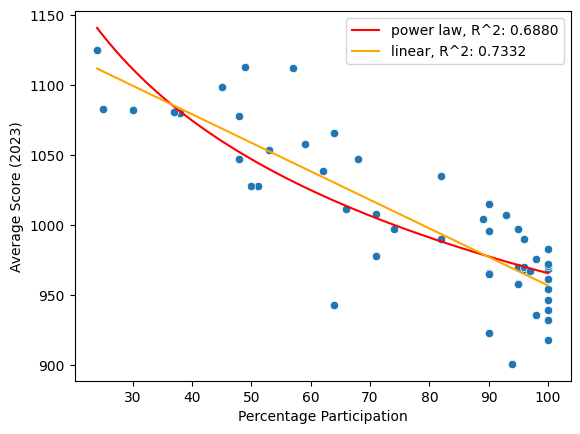

In [24]:
anomaly.anomaly(combined_scores, separate_years=True)